In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor, as_completed
import warnings

In [0]:
#Declaring on used variables
N = 10**7
u = 10**-6
s = 0.05
H = 2.0
epsilon = 10**-4
freq_init = [1,0,0,0]

In [0]:
def freqs_after_genetic_drift(freq_init):
  
  #Calculating frequencies after mutation
  x = freq_init
  mutation_x0 = (1-u)*(1-u)*x[0] + (1-u)*u*x[1] + (1-u)*u*x[2] + u*u*x[3]
  mutation_x1 = (1-u)*(1-u)*x[1] + (1-u)*u*x[0] + (1-u)*u*x[3] + u*u*x[2]
  mutation_x2 = (1-u)*(1-u)*x[2] + (1-u)*u*x[0] + (1-u)*u*x[3] + u*u*x[1]
  mutation_x3 = (1-u)*(1-u)*x[3] + (1-u)*u*x[1] + (1-u)*u*x[2] + u*u*x[0]
  freq_mutation = np.array([mutation_x0, mutation_x1, mutation_x2, mutation_x3])
  
  #Calculating frequencies after selection
  w = [1,1-s,1-s,1+s*H]
  denom = np.sum(np.multiply(freq_mutation,w))
  selection_x0 = w[0] * mutation_x0 / denom
  selection_x1 = w[1] * mutation_x1 / denom
  selection_x2 = w[2] * mutation_x2 / denom
  selection_x3 = w[3] * mutation_x3 / denom
  
  #Calculating frequencies after genetic drift
  multinomial = np.random.multinomial(N, [selection_x0, selection_x1, selection_x2, selection_x3])
  genetic_drift_x0 = multinomial[0] / N
  genetic_drift_x1 = multinomial[1] / N
  genetic_drift_x2 = multinomial[2] / N
  genetic_drift_x3 = multinomial[3] / N

  return [genetic_drift_x0, genetic_drift_x1, genetic_drift_x2, genetic_drift_x3]

In [0]:
def simulation(freq_init, buflen = 1000):
    
    freq = np.empty((buflen,4))
    freq[0] = freq_init
    t, fixation_AB, extinction_AB, first_AB  = 0,0,0,0
    
    #Measuring the time until first AB appeared
    while freq[t][3] == 0:  
        t += 1
        
        #Increasing the size of the array
        if t == len(freq):
            freq = np.concatenate((freq, np.empty((buflen,4))),axis = 0)
            
        freq[t] = freqs_after_genetic_drift(freq[t-1])    
    first_AB = t #Storing the value of the time when the first AB appeared    
    
    #Measuring the time until fixation or extinction happening
    while (0 < freq[t][3] < 1 - epsilon):
        t += 1
        
        #Increasing the size of the array
        if t == len(freq):
            freq = np.concatenate((freq, np.empty((buflen,4))), axis = 0)
        freq[t] = freqs_after_genetic_drift(freq[t-1])
    
    if(freq[t][3] > 0.99):
      fixation_AB = t #Storing the value of the time it first got to fixation
    if(freq[t][3] == 0):
      extinction_AB = t #Storing the value of the time it first got to extinction
    
    return freq[:t+1].copy(), first_AB, fixation_AB, extinction_AB
      

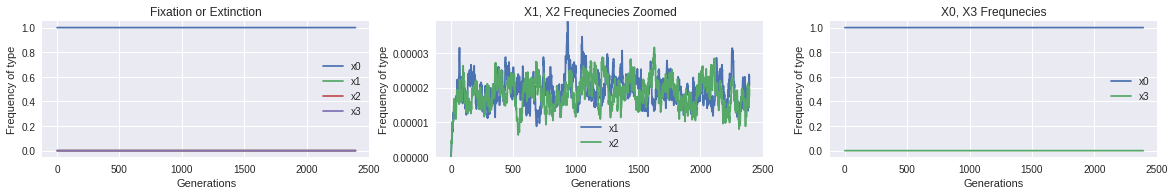

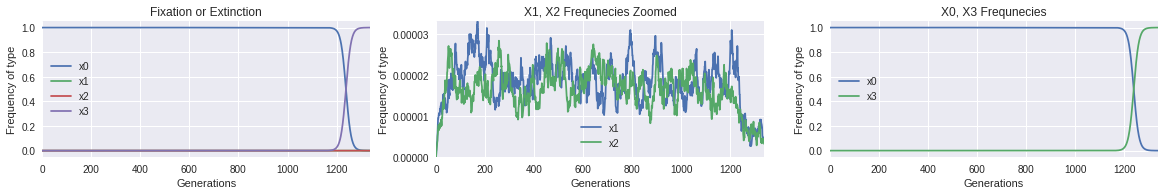

In [135]:
def print_drawings():
  freqs_arr,first_AB,fixation_AB,extinction_AB = simulation(np.array(freq_init))
  fig, ax = plt.subplots(1,3, figsize=(20, 1))
  x0 = freqs_arr[:,0]
  x1 = freqs_arr[:,1]
  x2 = freqs_arr[:,2]
  x3 = freqs_arr[:,3]
  ax[0].plot(x0, label = 'x0')
  ax[0].plot(x1, label = 'x1')
  ax[0].plot(x2, label = 'x2')
  ax[0].plot(x3, label = 'x3')
  ax[0].set_xlabel('Generations')
  ax[0].set_ylabel('Frequency of type')
  ax[0].set_title("Fixation or Extinction")
  ax[0].legend()
  #Extracting max value for y limits
  max_aB = np.max(x1)
  max_Ab = np.max(x2)
  max_aB_Ab = np.max([max_aB,max_Ab])
  ax[1].plot(x1,label = 'x1')
  ax[1].plot(x2,label = 'x2')
  ax[1].set_xlabel('Generations')
  ax[1].set_ylabel('Frequency of type')
  ax[1].legend()
  ax[1].set_title("X1, X2 Frequnecies Zoomed")
  ax[1].set_ylim([0, max_aB_Ab])
  
  ax[2].plot(x0,label = 'x0')
  ax[2].plot(x3,label = 'x3')
  ax[2].set_xlabel('Generations')
  ax[2].set_ylabel('Frequency of type')
  ax[2].legend()
  ax[2].set_title("X0, X3 Frequnecies")
  #Checking if its fixation or whether its extinction.
  if (fixation_AB != 0):
    ax[0].set_xlim([0, fixation_AB])
    ax[1].set_xlim([0, fixation_AB])
    ax[2].set_xlim([0, fixation_AB])
    
  plt.subplots_adjust(bottom = -1)

print_drawings()
print_drawings()


In [0]:
def data_illustration(num_of_simulations=5000):
  fixation_first_AB_counter, simulation_counter, first_AB_results, extinction_AB_results, fixation_AB_results = 0, 0, np.zeros(num_of_simulations), np.zeros(num_of_simulations), np.zeros(num_of_simulations)
  while simulation_counter < num_of_simulations:
    freqs_arr,first_AB,fixation_AB,extinction_AB = simulation(freq_init)
    
    #counting fixated
    if (fixation_AB != 0): 
      fixation_first_AB_counter = fixation_first_AB_counter + 1   
    first_AB_results[simulation_counter] = first_AB
    fixation_AB_results[simulation_counter] = fixation_AB
    extinction_AB_results[simulation_counter] = extinction_AB
    simulation_counter = simulation_counter + 1
  probability_newly_appeared_fixation = fixation_first_AB_counter
  return extinction_AB_results, first_AB_results, fixation_AB_results, fixation_first_AB_counter

In [0]:
simulation_num = 25000
extinction_AB_results_of_all_process = np.array([])
first_AB_results_of_all_process = np.array([])
fixation_AB_results_of_all_process = np.array([]) 
cpus_number = cpu_count()
fixation_first_AB_counter_of_all_process = 0
kwargs = dict(num_of_simulations = int(simulation_num/cpus_number))



f = data_illustration
#executing each process seperately
with ProcessPoolExecutor(cpus_number) as ex:
  futures = []
  cpu_index_arr = np.arange(cpus_number)
  futures = [ex.submit(data_illustration,**kwargs) for _ in cpu_index_arr]
  
#collecting the results
results = []
for fut in as_completed(futures):
  if fut.exception():
    warnings.warn(str(fut.exception()))
  else:
    extinction_AB_results, first_AB_results, fixation_AB_results, fixation_first_AB_counter = fut.result()
    fixation_first_AB_counter_of_all_process+=fixation_first_AB_counter
    extinction_AB_results_of_all_process = np.concatenate((extinction_AB_results_of_all_process,extinction_AB_results), axis = 0)
    first_AB_results_of_all_process = np.concatenate((first_AB_results_of_all_process,first_AB_results), axis = 0)
    fixation_AB_results_of_all_process = np.concatenate((fixation_AB_results_of_all_process,fixation_AB_results), axis = 0)
probability_newly_appeared_fixation = fixation_first_AB_counter_of_all_process/simulation_num
    

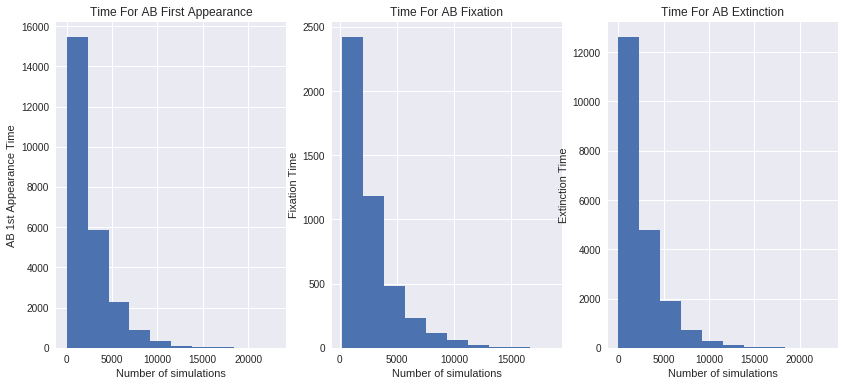

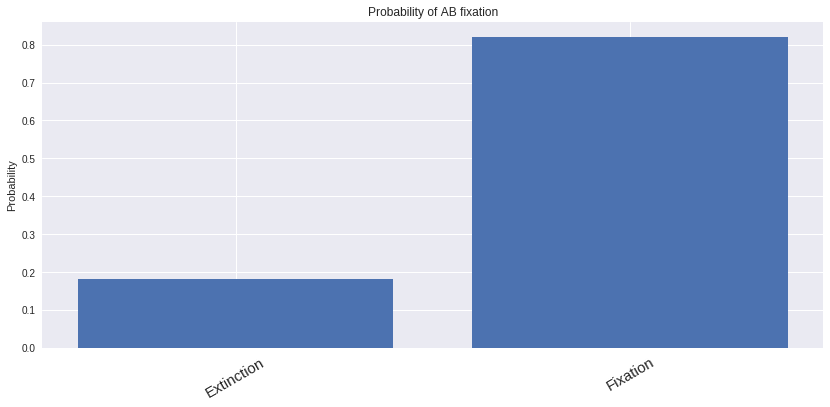

<Figure size 1008x432 with 0 Axes>

In [122]:
extinction_AB_results = extinction_AB_results_of_all_process
first_AB_results = first_AB_results_of_all_process
fixation_AB_results =  fixation_AB_results_of_all_process
probability_newly_appeared_fixation = probability_newly_appeared_fixation
fig, ax = plt.subplots(1,3, figsize=(14, 6))

#The distribution of the waiting time for appearance of the double-mutant
ax[0].hist(first_AB_results, label = "AB first appearance")
ax[0].set(xlabel='Number of simulations', ylabel='AB 1st Appearance Time')
ax[0].set_title("Time For AB First Appearance")

#The distribution of the waiting time for fixation of a double-mutant (given it appeared and fixed)
fixation_AB_appeared_fixed = fixation_AB_results[fixation_AB_results!=0]
ax[1].hist(fixation_AB_appeared_fixed)
ax[1].set(xlabel='Number of simulations', ylabel='Fixation Time')
ax[1].set_title("Time For AB Fixation")

#The distribution of the waiting time for extinction of a double-mutant (given it appeared and did not fix)
extinction_AB_appeared_not_fixed = extinction_AB_results[extinction_AB_results!=0]
ax[2].hist(extinction_AB_appeared_not_fixed)
ax[2].set(xlabel='Number of simulations', ylabel='Extinction Time')
ax[2].set_title("Time For AB Extinction")

#The fixation probability of a newly appeared double-mutant
prob_arr = np.array([probability_newly_appeared_fixation,(1-probability_newly_appeared_fixation)])
name_arr = ["Extinction","Fixation"]
index = np.array([0,1])
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
plt.bar(index,prob_arr)
plt.xticks(index, name_arr, fontsize=15, rotation=30)
plt.ylabel('Probability')
plt.title("Probability of AB fixation")
plt.figure(figsize=(14, 6))
plt.subplots_adjust(left = -1)
